0
275
550
825
1100
1375
1650
1925
2200
2475
2750
3025
3300
3575
3850
4125
4400
4675
4950
5225
5500
5775
done
6.668748874716229


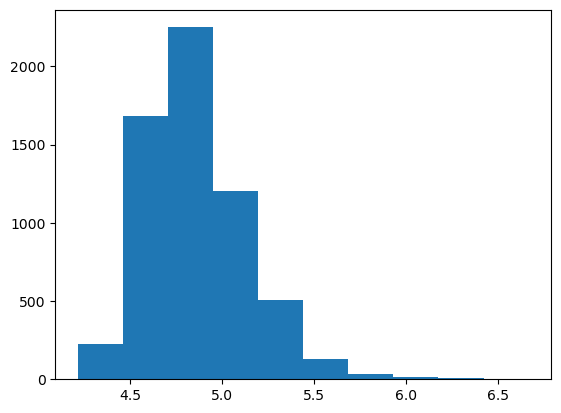

In [2]:
import pycbc.noise
import pycbc.psd
import matplotlib.pyplot as plt
from pycbc.filter import matched_filter
from pycbc.waveform import get_td_waveform
from pycbc.frame import write_frame
from pycbc.filter import sigma
import numpy as np
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.filter import resample_to_delta_t, highpass





data=[]
fs=4096
flow = 10.0
t=128 #TOTAL TIME OF THE DATA
delta_f = 1.0 / t

m = 36 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=m,
                     mass2=m,
                     delta_t=2/fs,
                     f_lower=20)





for i in range(6050):
    psd=pycbc.psd.analytical.aLIGOZeroDetLowPower(t*2048+1,delta_f,flow)

    
    ts=pycbc.noise.gaussian.noise_from_psd(fs*t,1./fs,psd)
    ts = resample_to_delta_t(ts, 1.0/fs)
   

    
    ts.start_time = 0
    
    strain=ts

    strain = resample_to_delta_t(highpass(strain, 15.0), 1.0/2048)
    
    conditioned = strain.crop(2, 2)
    
    
    
    psd = conditioned.psd(4)

    
    psd = interpolate(psd, conditioned.delta_f)

    psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                      low_frequency_cutoff=15)
    
    hp.resize(len(conditioned))
    template = hp.cyclic_time_shift(hp.start_time)

    
    
    
    snr = matched_filter(template, conditioned,
                         psd=psd, low_frequency_cutoff=20)
    

    snr = snr.crop(4 + 4, 4)
    

    peak = abs(snr).numpy().argmax()
    snrp = snr[peak]
    time = snr.sample_times[peak]
 
    data.append(abs(snrp))
    if i%275==0:
        print(i)
print("done")


plt.hist(data)
print(max(data))